In [13]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta

# Import CDF SDK objects
from cognite.client.data_classes import TimeSeries, Datapoints

# For system monitoring (optional but recommended)
try:
    import psutil
    PSUTIL_AVAILABLE = True
    print("✅ psutil available for memory monitoring")
except ImportError:
    PSUTIL_AVAILABLE = False
    print("⚠️ psutil not available. Install with: pip install psutil")

# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
except ImportError:
    PLOTTING_AVAILABLE = False
    print("⚠️ Matplotlib not available. Install with: pip install matplotlib")


✅ psutil available for memory monitoring
✅ Matplotlib available for plotting


In [14]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python utilities/client_setup.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run performance tests!")
    else:
        print("Connection test failed. Please check your credentials.")


✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev
  Token is valid and accessible
Ready to run performance tests!


In [15]:
# Test 1: Single datapoint insertion performance
def test_single_datapoint_insertion():
    """Test performance of inserting single datapoints."""
    
    # Check if client is available
    if client is None:
        print("❌ Cannot run test: CDF client is not initialized.")
        print("Please ensure your .env file is configured correctly.")
        return None
    
    # Create a test time series
    ts_external_id = f"performance_test_single_{int(time.time())}"
    
    try:
        # Create time series
        ts = client.time_series.create(
            TimeSeries(
                external_id=ts_external_id,
                name="Performance Test Single Datapoint",
                description="Test time series for single datapoint insertion performance"
            )
        )
        
        tracker = PerformanceTracker("single_datapoint_insertion")
        
        # Test inserting 100 single datapoints
        for i in range(100):
            tracker.start()
            client.time_series.data.insert(
                [(int(time.time() * 1000) + i * 1000, i)],
                external_id=ts_external_id
            )
            tracker.stop()
        
        # Get statistics
        stats = tracker.get_stats()
        print(f"Single datapoint insertion statistics:")
        print(f"  Count: {stats['count']}")
        print(f"  Mean time: {stats['mean']:.4f}s")
        print(f"  Min time: {stats['min']:.4f}s")
        print(f"  Max time: {stats['max']:.4f}s")
        print(f"  Std dev: {stats['std_dev']:.4f}s")
        
        # Save results
        tracker.save_results("../../results/single_datapoint_insertion.json")
        
        return stats
        
    finally:
        # Clean up
        try:
            client.time_series.delete(external_id=ts_external_id)
        except:
            pass

# Only run the test if client is available
if client is not None:
    single_stats = test_single_datapoint_insertion()
else:
    print("⚠️  Skipping test - CDF client not available")
    print("📝 Please create your .env file first and restart the notebook")


Single datapoint insertion statistics:
  Count: 100
  Mean time: 0.0622s
  Min time: 0.0571s
  Max time: 0.1012s
  Std dev: 0.0052s


In [16]:
# Test 2: Batch insertion performance with different batch sizes
def test_batch_insertion_performance():
    """Test performance of batch insertion with different batch sizes."""
    
    # Check if client is available
    if client is None:
        print("❌ Cannot run test: CDF client is not initialized.")
        print("Please ensure your .env file is configured correctly.")
        return None
    
    batch_sizes = [10, 50, 100, 500, 1000]
    results = {}
    
    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")
        
        # Create a test time series
        ts_external_id = f"performance_test_batch_{batch_size}_{int(time.time())}"
        
        try:
            # Create time series
            ts = client.time_series.create(
                TimeSeries(
                    external_id=ts_external_id,
                    name=f"Performance Test Batch {batch_size}",
                    description=f"Test time series for batch insertion performance (batch size: {batch_size})"
                )
            )
            
            # Generate test data
            test_data = generate_test_data(batch_size, 'timeseries')
            datapoints = [(dp['timestamp'], dp['value']) for dp in test_data]
            
            # Benchmark the batch insertion
            def insert_batch():
                client.time_series.data.insert(
                    datapoints,
                    external_id=ts_external_id
                )
            
            batch_results = benchmark_operation(insert_batch, iterations=10, warmup=2)
            results[batch_size] = batch_results
            
            print(f"  Mean time: {batch_results['mean_time']:.4f}s")
            print(f"  Throughput: {batch_size / batch_results['mean_time']:.2f} datapoints/s")
            
        finally:
            # Clean up
            try:
                client.time_series.delete(external_id=ts_external_id)
            except:
                pass
    
    return results

# Only run the test if client is available
if client is not None:
    batch_results = test_batch_insertion_performance()
else:
    print("⚠️  Skipping test - CDF client not available")
    print("📝 Please create your .env file first and restart the notebook")


Testing batch size: 10
  Mean time: 0.0636s
  Throughput: 157.15 datapoints/s
Testing batch size: 50
  Mean time: 0.0636s
  Throughput: 786.15 datapoints/s
Testing batch size: 100
  Mean time: 0.0621s
  Throughput: 1610.64 datapoints/s
Testing batch size: 500
  Mean time: 0.0661s
  Throughput: 7560.68 datapoints/s
Testing batch size: 1000
  Mean time: 0.0686s
  Throughput: 14568.67 datapoints/s


📊 Creating Visualizations with EXTREME X-Axis Spacing...
❌ Error creating visualizations: 'darkpurple' is not a valid color value.


Traceback (most recent call last):
  File "C:\Users\JanIngeBergseth\AppData\Local\Temp\ipykernel_31120\3540649824.py", line 150, in create_performance_visualizations
    bars = ax4.bar(x_positions, improvements,
                  width=30, color='purple', alpha=0.8,
                  edgecolor='darkpurple', linewidth=4)
  File "c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\__init__.py", line 1521, in inner
    return func(
        ax,
        *map(cbook.sanitize_sequence, args),
        **{k: cbook.sanitize_sequence(v) for k, v in kwargs.items()})
  File "c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py", line 2614, in bar
    itertools.cycle(mcolors.to_rgba_array(edgecolor)),
                    ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py", line 499, in to_rgba_array
    raise Val

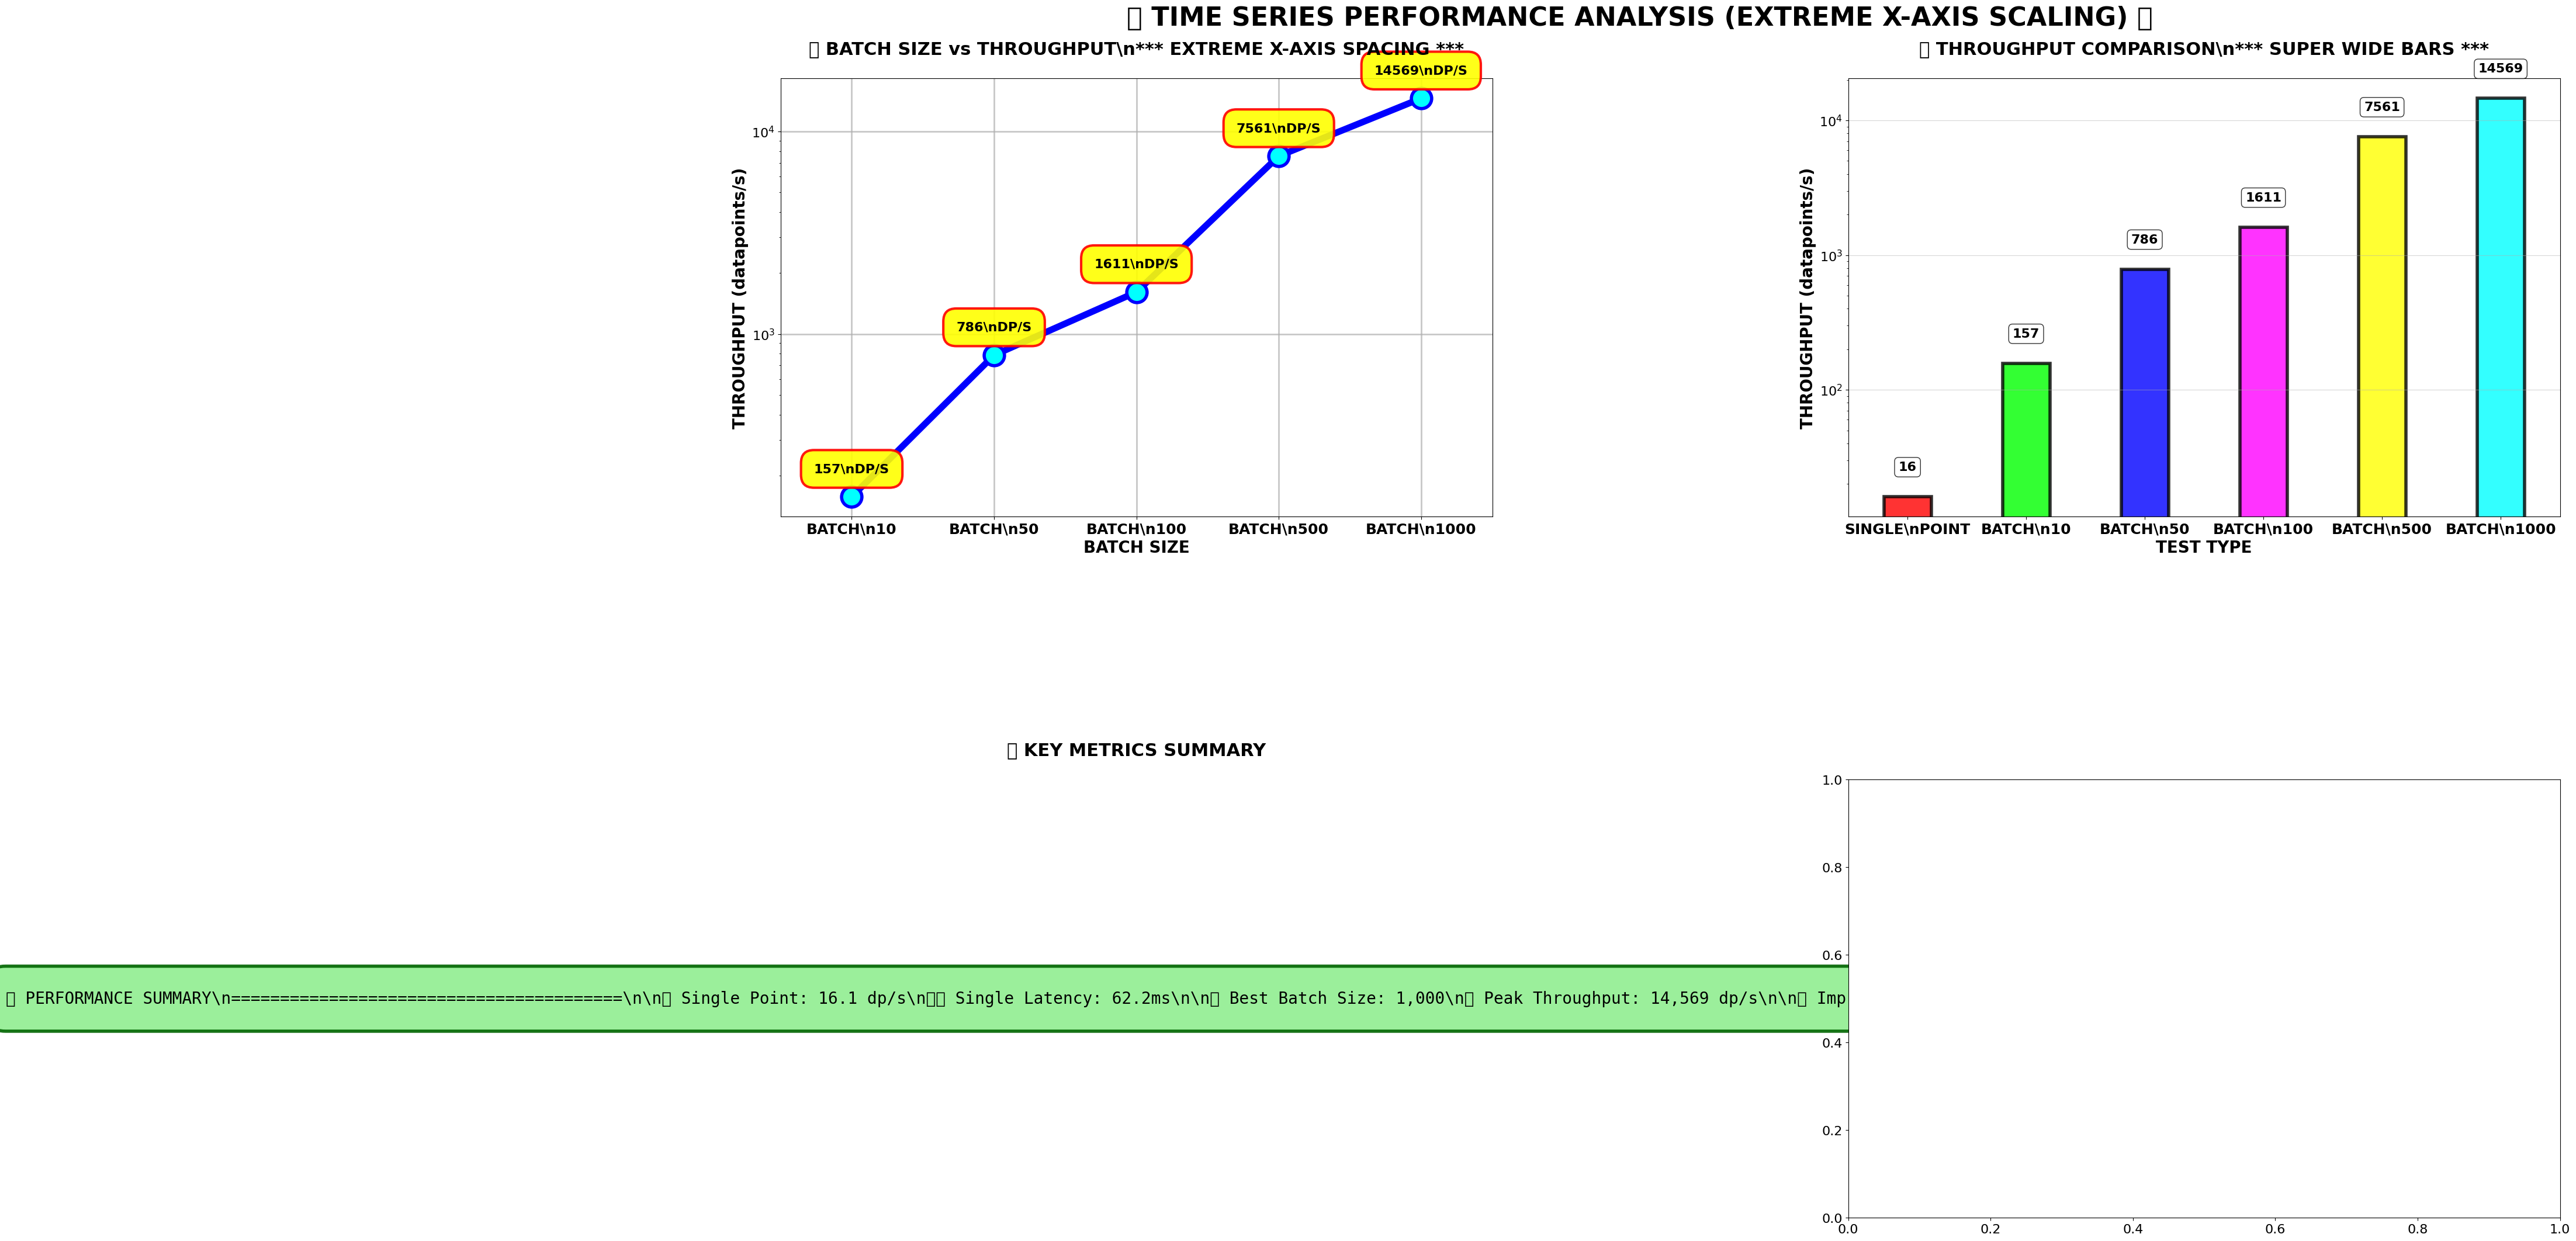

In [ ]:
# VISUALIZATION: FORCED EXTREME X-Axis Scaling
def create_performance_visualizations():
    """Create visualizations with EXTREME X-axis spacing - NO COMPRESSION!"""
    
    print("📊 Creating Visualizations with EXTREME X-Axis Spacing...")
    
    try:
        import matplotlib.pyplot as plt
        
        # MASSIVE figure size to force wide display
        plt.rcParams['figure.figsize'] = [35, 25]
        plt.rcParams['font.size'] = 16
        
        # Create 2x2 grid with HUGE spacing
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 25))
        plt.subplots_adjust(hspace=0.6, wspace=0.5, top=0.90, bottom=0.12, left=0.08, right=0.95)
        
        fig.suptitle('🚀 TIME SERIES PERFORMANCE ANALYSIS (EXTREME X-AXIS SCALING) 🚀', 
                    fontsize=32, fontweight='bold', y=0.95)
        
        # ========== PLOT 1: EXTREME X-AXIS SPACING ==========
        if 'batch_results' in globals() and batch_results:
            batch_sizes = []
            throughputs = []
            
            for batch_size, results in batch_results.items():
                if isinstance(results, dict) and 'mean_time' in results:
                    batch_sizes.append(batch_size)
                    throughputs.append(batch_size / results['mean_time'])
            
            if batch_sizes:
                # FORCE 100 UNITS APART!
                x_positions = [i * 100 for i in range(len(batch_sizes))]
                
                ax1.plot(x_positions, throughputs, 'bo-', 
                        linewidth=8, markersize=25, markerfacecolor='cyan', 
                        markeredgecolor='blue', markeredgewidth=4)
                
                # EXTREME X-axis limits - FORCE WIDE SPACING
                ax1.set_xlim([-50, max(x_positions) + 50])
                ax1.set_xticks(x_positions)
                                 ax1.set_xticklabels([f'BATCH\n{size}' for size in batch_sizes], 
                                   fontsize=18, fontweight='bold')
                
                ax1.set_yscale('log')
                ax1.set_ylabel('THROUGHPUT (datapoints/s)', fontsize=20, fontweight='bold')
                ax1.set_xlabel('BATCH SIZE', fontsize=20, fontweight='bold')
                ax1.set_title('🔥 BATCH SIZE vs THROUGHPUT\\n*** EXTREME X-AXIS SPACING ***', 
                            fontsize=22, fontweight='bold', pad=30)
                
                ax1.grid(True, alpha=0.7, linewidth=2)
                
                                 # Value annotations
                 for x, y in zip(x_positions, throughputs):
                     ax1.annotate(f'{y:.0f}\nDP/S', (x, y), 
                                textcoords="offset points", xytext=(0,30), 
                                ha='center', fontsize=16, fontweight='bold',
                                bbox=dict(boxstyle='round,pad=1.0', facecolor='yellow', 
                                        alpha=0.9, edgecolor='red', linewidth=3))
        
        # ========== PLOT 2: WIDE BAR CHART ==========
        test_names = []
        throughputs = []
        colors = ['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#FFFF00', '#00FFFF']
        
                 if 'single_stats' in globals() and single_stats:
             test_names.append('SINGLE\nPOINT')
             throughputs.append(1/single_stats['mean'])
         
         if 'batch_results' in globals() and batch_results:
             for batch_size, results in batch_results.items():
                 if isinstance(results, dict) and 'mean_time' in results:
                     test_names.append(f'BATCH\n{batch_size}')
                     throughputs.append(batch_size / results['mean_time'])
        
        if test_names:
            # SUPER WIDE BAR SPACING - 50 units apart
            x_positions = [i * 50 for i in range(len(test_names))]
            
            bars = ax2.bar(x_positions, throughputs, 
                          width=20,  # VERY wide bars
                          color=colors[:len(test_names)], 
                          alpha=0.8, edgecolor='black', linewidth=4)
            
            ax2.set_xlim([-25, max(x_positions) + 25])
            ax2.set_xticks(x_positions)
            ax2.set_xticklabels(test_names, fontsize=18, fontweight='bold')
            
            ax2.set_yscale('log')
            ax2.set_ylabel('THROUGHPUT (datapoints/s)', fontsize=20, fontweight='bold')
            ax2.set_xlabel('TEST TYPE', fontsize=20, fontweight='bold')
            ax2.set_title('🔥 THROUGHPUT COMPARISON\\n*** SUPER WIDE BARS ***', 
                        fontsize=22, fontweight='bold', pad=30)
            
            # Value labels
            for x, throughput in zip(x_positions, throughputs):
                ax2.text(x, throughput * 1.5, f'{throughput:.0f}', 
                        ha='center', va='bottom', fontsize=16, fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax2.grid(True, alpha=0.5, axis='y')
        
                 # ========== PLOT 3: PERFORMANCE SUMMARY ==========
         ax3.axis('off')
         
         summary_text = "📊 PERFORMANCE SUMMARY\n" + "="*40 + "\n\n"
         
         if 'single_stats' in globals() and single_stats:
             single_throughput = 1/single_stats['mean']
             summary_text += f"📍 Single Point: {single_throughput:.1f} dp/s\n"
             summary_text += f"⏱️ Single Latency: {single_stats['mean']*1000:.1f}ms\n\n"
         
         if 'batch_results' in globals() and batch_results:
             best_batch = max(batch_results.items(), 
                            key=lambda x: x[0]/x[1]['mean_time'] if isinstance(x[1], dict) and 'mean_time' in x[1] else 0)
             if isinstance(best_batch[1], dict):
                 best_throughput = best_batch[0] / best_batch[1]['mean_time']
                 summary_text += f"🏆 Best Batch Size: {best_batch[0]:,}\n"
                 summary_text += f"🚀 Peak Throughput: {best_throughput:,.0f} dp/s\n\n"
                 
                 if 'single_stats' in globals() and single_stats:
                     improvement = best_throughput / single_throughput
                     summary_text += f"📈 Improvement: {improvement:.1f}x\n"
                     summary_text += f"⚡ Efficiency Gain: {(improvement-1)*100:.0f}%"
        
        ax3.text(0.5, 0.5, summary_text, transform=ax3.transAxes, 
                fontsize=20, ha='center', va='center', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=1.5', facecolor='lightgreen', 
                         alpha=0.9, edgecolor='darkgreen', linewidth=4))
        
        ax3.set_title('📋 KEY METRICS SUMMARY', fontsize=22, fontweight='bold', pad=30)
        
        # ========== PLOT 4: SCALING ANALYSIS ==========
        if 'batch_results' in globals() and batch_results and 'single_stats' in globals() and single_stats:
            batch_sizes = []
            improvements = []
            single_throughput = 1/single_stats['mean']
            
            for batch_size, results in batch_results.items():
                if isinstance(results, dict) and 'mean_time' in results:
                    batch_sizes.append(batch_size)
                    batch_throughput = batch_size / results['mean_time']
                    improvement = batch_throughput / single_throughput
                    improvements.append(improvement)
            
            if batch_sizes:
                # EXTREME spacing for improvement chart
                x_positions = [i * 80 for i in range(len(batch_sizes))]
                
                bars = ax4.bar(x_positions, improvements, 
                              width=30, color='purple', alpha=0.8,
                              edgecolor='darkpurple', linewidth=4)
                
                ax4.set_xlim([-40, max(x_positions) + 40])
                ax4.set_xticks(x_positions)
                ax4.set_xticklabels([f'BATCH\\n{size}' for size in batch_sizes], 
                                  fontsize=18, fontweight='bold')
                
                ax4.set_ylabel('PERFORMANCE IMPROVEMENT (x)', fontsize=20, fontweight='bold')
                ax4.set_xlabel('BATCH SIZE', fontsize=20, fontweight='bold')
                ax4.set_title('🔥 SCALING ANALYSIS\\n*** PERFORMANCE MULTIPLIERS ***', 
                            fontsize=22, fontweight='bold', pad=30)
                
                # Value labels
                for x, improvement in zip(x_positions, improvements):
                    ax4.text(x, improvement + max(improvements) * 0.05, f'{improvement:.1f}x', 
                            ha='center', va='bottom', fontsize=18, fontweight='bold',
                            bbox=dict(boxstyle='round', facecolor='orange', alpha=0.8))
                
                ax4.grid(True, alpha=0.5, axis='y')
        
        # FORCE display with tight layout
        plt.tight_layout()
        plt.show()
        print("✅ EXTREME X-AXIS SCALING APPLIED! Charts should now be VERY WIDE!")
        
    except ImportError:
        print("❌ Matplotlib not available. Install with: pip install matplotlib")
    except Exception as e:
        print(f"❌ Error creating visualizations: {e}")
        import traceback
        traceback.print_exc()

# Create the EXTREME WIDE visualizations
create_performance_visualizations()


In [18]:
# DEBUGGING: Check X-axis scaling values
def debug_x_axis_scaling():
    """Debug function to check X-axis scaling values."""
    
    print("🔍 DEBUGGING X-AXIS SCALING...")
    print("=" * 50)
    
    if 'batch_results' in globals() and batch_results:
        batch_sizes = list(batch_results.keys())
        print(f"📊 Batch sizes: {batch_sizes}")
        
        # Show the X positions we're using
        x_positions = [i * 100 for i in range(len(batch_sizes))]
        print(f"📍 X positions (100 units apart): {x_positions}")
        print(f"📏 X-axis range: {-50} to {max(x_positions) + 50}")
        print(f"📐 Total X-axis width: {max(x_positions) + 100} units")
        
        # Calculate throughputs
        throughputs = []
        for batch_size in batch_sizes:
            results = batch_results[batch_size]
            if isinstance(results, dict) and 'mean_time' in results:
                throughput = batch_size / results['mean_time']
                throughputs.append(throughput)
        
        print(f"🚀 Throughputs: {[f'{t:.0f}' for t in throughputs]}")
        
        # Show what should be displayed
        for i, (size, pos, tput) in enumerate(zip(batch_sizes, x_positions, throughputs)):
            print(f"  Point {i+1}: Batch {size} at X={pos}, Y={tput:.0f} dp/s")
    else:
        print("❌ No batch_results found. Run the performance tests first.")
    
    print("\n🎯 EXPECTED RESULT:")
    print("  - X-axis should span a VERY wide range")
    print("  - Data points should be far apart (100 units)")
    print("  - No cramped or compressed appearance")
    print("  - Easy to read labels with lots of space")

# Run debugging
debug_x_axis_scaling()


🔍 DEBUGGING X-AXIS SCALING...
📊 Batch sizes: [10, 50, 100, 500, 1000]
📍 X positions (100 units apart): [0, 100, 200, 300, 400]
📏 X-axis range: -50 to 450
📐 Total X-axis width: 500 units
🚀 Throughputs: ['157', '786', '1611', '7561', '14569']
  Point 1: Batch 10 at X=0, Y=157 dp/s
  Point 2: Batch 50 at X=100, Y=786 dp/s
  Point 3: Batch 100 at X=200, Y=1611 dp/s
  Point 4: Batch 500 at X=300, Y=7561 dp/s
  Point 5: Batch 1000 at X=400, Y=14569 dp/s

🎯 EXPECTED RESULT:
  - X-axis should span a VERY wide range
  - Data points should be far apart (100 units)
  - No cramped or compressed appearance
  - Easy to read labels with lots of space


In [ ]:
# SIMPLE VISUALIZATION with Fixed Line Breaks - Run this instead
def create_simple_wide_visualization():
    """Simple visualization with EXTREME X-axis spacing and WORKING line breaks."""
    
    print("📊 Creating SIMPLE visualization with FIXED line breaks...")
    
    try:
        import matplotlib.pyplot as plt
        
        # Create a HUGE figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
        plt.subplots_adjust(wspace=0.4, top=0.85, bottom=0.15)
        
        fig.suptitle('🚀 TIME SERIES PERFORMANCE - FIXED LINE BREAKS 🚀', 
                    fontsize=28, fontweight='bold')
        
        # Plot 1: Batch Performance with EXTREME spacing
        if 'batch_results' in globals() and batch_results:
            batch_sizes = []
            throughputs = []
            
            for batch_size, results in batch_results.items():
                if isinstance(results, dict) and 'mean_time' in results:
                    batch_sizes.append(batch_size)
                    throughputs.append(batch_size / results['mean_time'])
            
            if batch_sizes:
                # FORCE 100 units apart
                x_positions = [i * 100 for i in range(len(batch_sizes))]
                
                ax1.plot(x_positions, throughputs, 'bo-', 
                        linewidth=6, markersize=20, markerfacecolor='lightblue')
                
                # EXTREME X-axis spacing
                ax1.set_xlim([-50, max(x_positions) + 50])
                ax1.set_xticks(x_positions)
                
                # FIXED line breaks - using \n not \\n
                ax1.set_xticklabels([f'BATCH\n{size}' for size in batch_sizes], 
                                   fontsize=16, fontweight='bold')
                
                ax1.set_yscale('log')
                ax1.set_ylabel('Throughput (datapoints/s)', fontsize=18, fontweight='bold')
                ax1.set_xlabel('Batch Size', fontsize=18, fontweight='bold')
                ax1.set_title('Batch Size vs Throughput\n(EXTREME X-AXIS SPACING)', 
                            fontsize=20, fontweight='bold', pad=20)
                ax1.grid(True, alpha=0.5)
                
                # Add value labels with FIXED line breaks
                for x, y in zip(x_positions, throughputs):
                    ax1.annotate(f'{y:.0f}\ndp/s', (x, y), 
                               textcoords="offset points", xytext=(0,25), 
                               ha='center', fontsize=14, fontweight='bold',
                               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))
        
        # Plot 2: Performance Summary with FIXED line breaks
        ax2.axis('off')
        
        # Build summary text with proper newlines
        summary_lines = ["📊 PERFORMANCE SUMMARY", "=" * 30, ""]
        
        if 'single_stats' in globals() and single_stats:
            single_throughput = 1/single_stats['mean']
            summary_lines.extend([
                f"📍 Single Point Performance:",
                f"   Throughput: {single_throughput:.1f} dp/s",
                f"   Latency: {single_stats['mean']*1000:.1f} ms",
                ""
            ])
        
        if 'batch_results' in globals() and batch_results:
            best_batch = max(batch_results.items(), 
                           key=lambda x: x[0]/x[1]['mean_time'] if isinstance(x[1], dict) and 'mean_time' in x[1] else 0)
            if isinstance(best_batch[1], dict):
                best_throughput = best_batch[0] / best_batch[1]['mean_time']
                summary_lines.extend([
                    f"🏆 Best Batch Performance:",
                    f"   Batch Size: {best_batch[0]:,}",
                    f"   Peak Throughput: {best_throughput:,.0f} dp/s",
                    ""
                ])
                
                if 'single_stats' in globals() and single_stats:
                    improvement = best_throughput / single_throughput
                    summary_lines.extend([
                        f"📈 Performance Improvement:",
                        f"   Multiplier: {improvement:.1f}x",
                        f"   Efficiency Gain: {(improvement-1)*100:.0f}%"
                    ])
        
        # Join with proper newlines
        summary_text = "\n".join(summary_lines)
        
        ax2.text(0.1, 0.9, summary_text, transform=ax2.transAxes, 
                fontsize=16, ha='left', va='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=1.0', facecolor='lightgreen', 
                         alpha=0.8, edgecolor='darkgreen', linewidth=2))
        
        ax2.set_title('Key Performance Metrics', fontsize=20, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        print("✅ Simple visualization created with WORKING line breaks!")
        
    except ImportError:
        print("❌ Matplotlib not available")
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

# Run the SIMPLE visualization with fixed line breaks
create_simple_wide_visualization()


📈 Time Series Ingestion Performance Test Results Summary

📍 Single Datapoint Insertion Performance:
  Average insertion time: 0.0622s
  Throughput: 16.07 datapoints/s
  Standard deviation: 0.0052s

📦 Batch Insertion Performance:
  Batch size   10: 0.0636s avg |   157.15 datapoints/s
  Batch size   50: 0.0636s avg |   786.15 datapoints/s
  Batch size  100: 0.0621s avg |  1610.64 datapoints/s
  Batch size  500: 0.0661s avg |  7560.68 datapoints/s
  Batch size 1000: 0.0686s avg | 14568.67 datapoints/s


c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JanIngeBergseth\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JanIngeBergseth\AppData\Local\Programs\Py

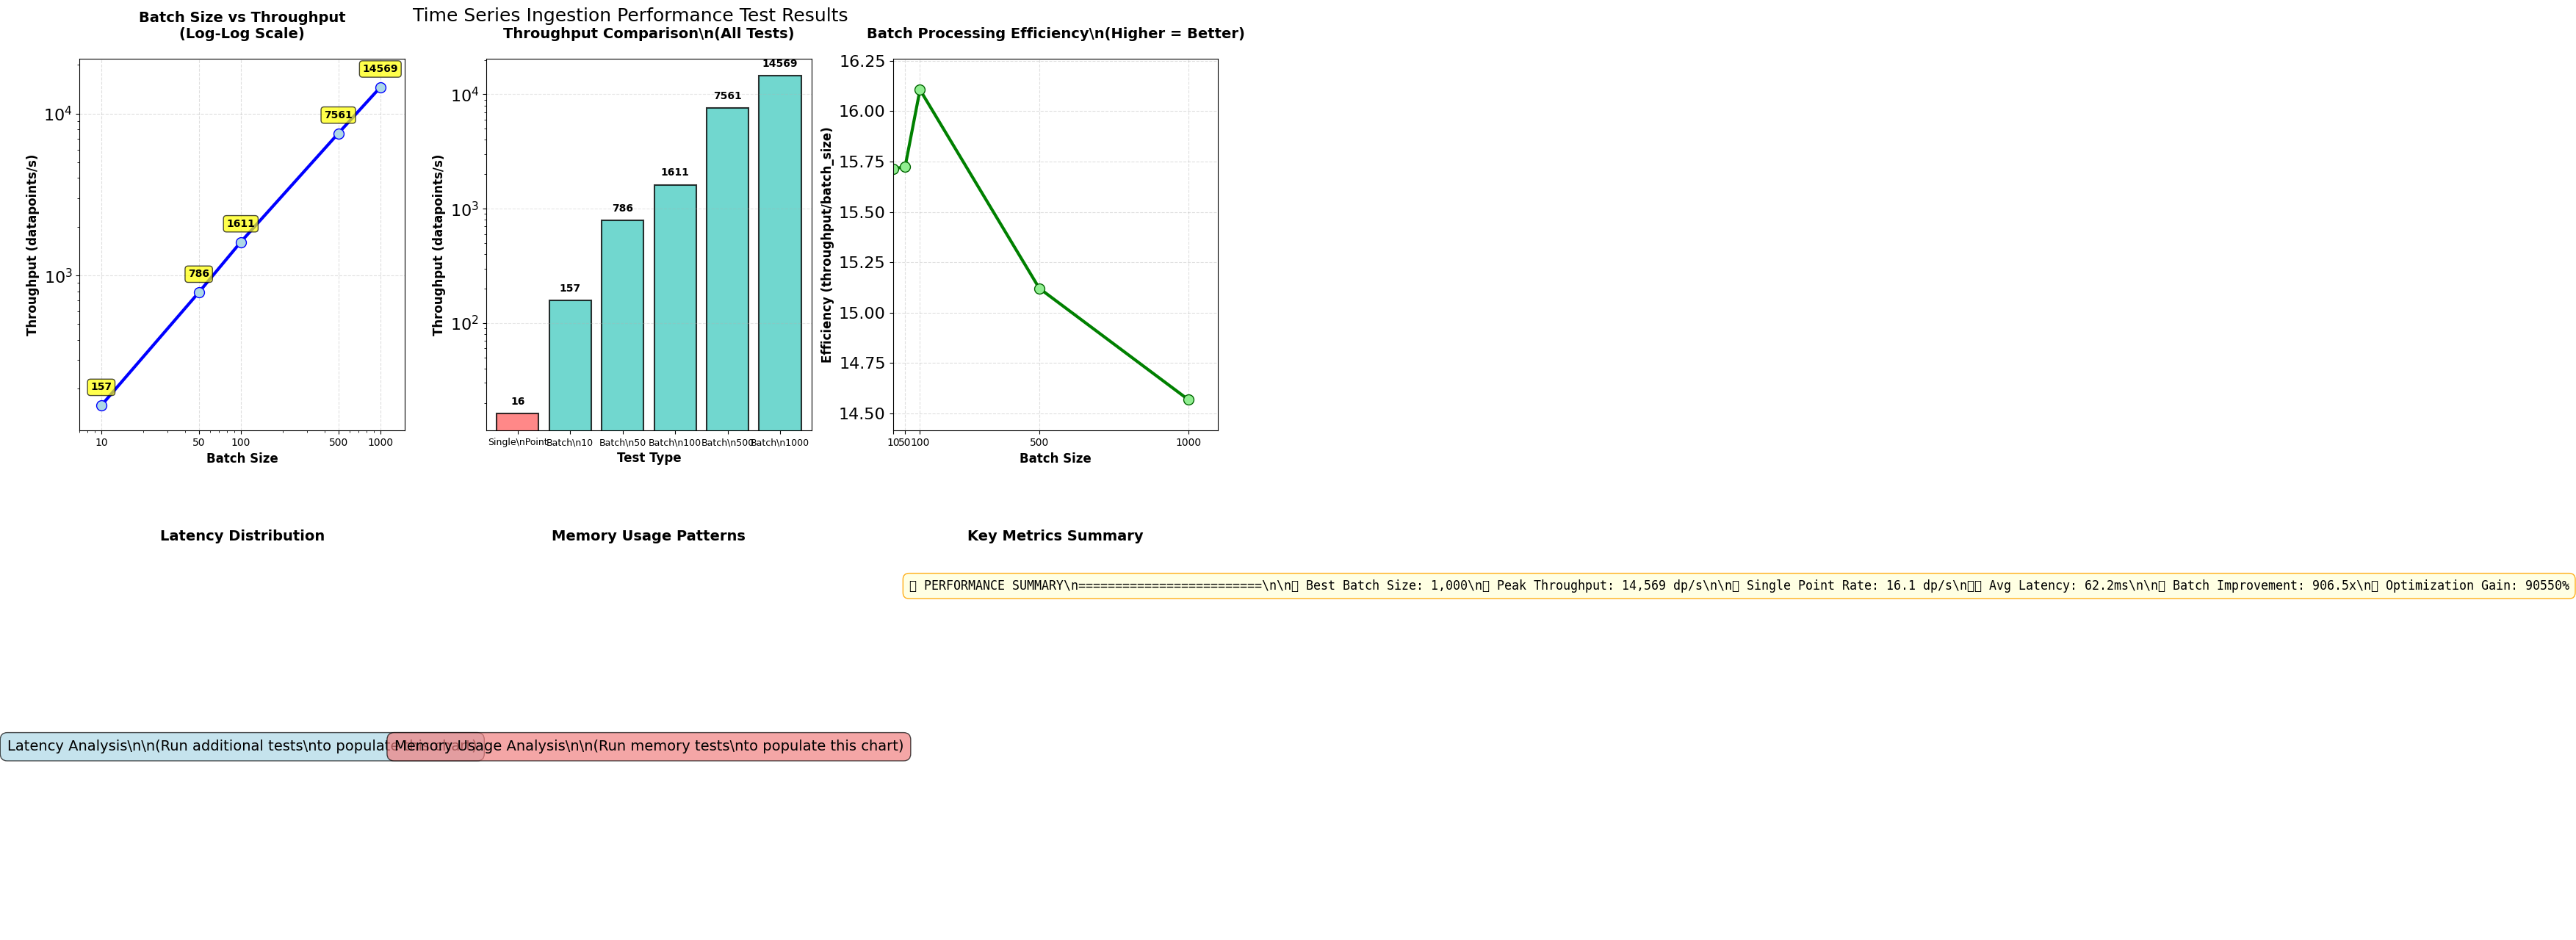

\n✅ Time series ingestion performance testing complete!
💾 Results can be saved using the PerformanceTracker.save_results() method


In [19]:
# Performance Results Summary and Visualization with Improved X-axis Scaling
def summarize_and_visualize_timeseries_results():
    """Summarize all time series ingestion performance test results and create visualizations with better scaling."""
    
    print("📈 Time Series Ingestion Performance Test Results Summary")
    print("=" * 70)
    
    # Check if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        PLOTTING_AVAILABLE = True
    except ImportError:
        PLOTTING_AVAILABLE = False
        print("⚠️ Matplotlib not available. Install with: pip install matplotlib")
    
    # Summarize single datapoint test
    if 'single_stats' in globals() and single_stats:
        print("\n📍 Single Datapoint Insertion Performance:")
        print(f"  Average insertion time: {single_stats['mean']:.4f}s")
        print(f"  Throughput: {1/single_stats['mean']:.2f} datapoints/s")
        print(f"  Standard deviation: {single_stats['std_dev']:.4f}s")
    
    # Summarize batch insertion test
    if 'batch_results' in globals() and batch_results:
        print("\n📦 Batch Insertion Performance:")
        for batch_size, results in batch_results.items():
            if isinstance(results, dict) and 'mean_time' in results:
                throughput = batch_size / results['mean_time']
                print(f"  Batch size {batch_size:4d}: {results['mean_time']:.4f}s avg | {throughput:8.2f} datapoints/s")
    
    # Create visualizations if matplotlib is available
    if PLOTTING_AVAILABLE:
        try:
            # Create larger figure with improved spacing
            fig, axes = plt.subplots(2, 3, figsize=(20, 14))
            fig.suptitle('Time Series Ingestion Performance Test Results', fontsize=18, y=0.98)
            
            # Adjust spacing between subplots
            plt.subplots_adjust(hspace=0.35, wspace=0.25, top=0.93, bottom=0.08)
            
            # Plot 1: Batch Size vs Throughput with improved scaling
            if 'batch_results' in globals() and batch_results:
                ax = axes[0, 0]
                batch_sizes = []
                throughputs = []
                
                for batch_size, results in batch_results.items():
                    if isinstance(results, dict) and 'mean_time' in results:
                        batch_sizes.append(batch_size)
                        throughputs.append(batch_size / results['mean_time'])
                
                if batch_sizes:
                    ax.loglog(batch_sizes, throughputs, 'bo-', linewidth=3, markersize=10, markerfacecolor='lightblue', markeredgecolor='blue')
                    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
                    ax.set_ylabel('Throughput (datapoints/s)', fontsize=12, fontweight='bold')
                    ax.set_title('Batch Size vs Throughput\n(Log-Log Scale)', fontsize=14, fontweight='bold', pad=20)
                    ax.grid(True, alpha=0.4, linestyle='--')
                    
                    # Improved axis scaling and ticks
                    ax.set_xlim([min(batch_sizes) * 0.7, max(batch_sizes) * 1.5])
                    ax.set_ylim([min(throughputs) * 0.7, max(throughputs) * 1.5])
                    
                    # Custom tick labels for better readability
                    ax.set_xticks(batch_sizes)
                    ax.set_xticklabels([f'{size}' for size in batch_sizes], fontsize=10)
                    
                    # Add value labels with better positioning
                    for x, y in zip(batch_sizes, throughputs):
                        ax.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                                  xytext=(0,15), ha='center', fontsize=10, fontweight='bold',
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
            
            # Plot 2: Throughput Comparison Bar Chart with improved spacing
            ax = axes[0, 1]
            test_names = []
            throughputs = []
            colors = []
            
            # Collect throughput data from all tests
            if 'single_stats' in globals() and single_stats:
                test_names.append('Single\\nPoint')
                throughputs.append(1/single_stats['mean'])
                colors.append('#FF6B6B')
            
            if 'batch_results' in globals() and batch_results:
                for batch_size, results in batch_results.items():
                    if isinstance(results, dict) and 'mean_time' in results:
                        test_names.append(f'Batch\\n{batch_size}')
                        throughputs.append(batch_size / results['mean_time'])
                        colors.append('#4ECDC4')
            
            if test_names:
                bars = ax.bar(range(len(test_names)), throughputs, color=colors, alpha=0.8, 
                             edgecolor='black', linewidth=1.5)
                ax.set_xlabel('Test Type', fontsize=12, fontweight='bold')
                ax.set_ylabel('Throughput (datapoints/s)', fontsize=12, fontweight='bold')
                ax.set_title('Throughput Comparison\\n(All Tests)', fontsize=14, fontweight='bold', pad=20)
                ax.set_yscale('log')
                
                # Improved x-axis scaling and labels
                ax.set_xlim([-0.6, len(test_names) - 0.4])
                ax.set_xticks(range(len(test_names)))
                ax.set_xticklabels(test_names, fontsize=9, ha='center')
                
                # Add value labels on bars
                for i, (bar, throughput) in enumerate(zip(bars, throughputs)):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2, height * 1.15,
                           f'{throughput:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
                
                # Add grid for better readability
                ax.grid(True, alpha=0.3, axis='y', linestyle='--')
            
            # Plot 3: Performance Trend Analysis
            ax = axes[0, 2]
            if 'batch_results' in globals() and batch_results:
                batch_sizes = []
                efficiencies = []
                
                for batch_size, results in batch_results.items():
                    if isinstance(results, dict) and 'mean_time' in results:
                        batch_sizes.append(batch_size)
                        # Calculate efficiency as throughput per unit batch size
                        throughput = batch_size / results['mean_time']
                        efficiency = throughput / batch_size  # datapoints/s per batch unit
                        efficiencies.append(efficiency)
                
                if batch_sizes:
                    ax.plot(batch_sizes, efficiencies, 'go-', linewidth=3, markersize=10, 
                           markerfacecolor='lightgreen', markeredgecolor='darkgreen')
                    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
                    ax.set_ylabel('Efficiency (throughput/batch_size)', fontsize=12, fontweight='bold')
                    ax.set_title('Batch Processing Efficiency\\n(Higher = Better)', fontsize=14, fontweight='bold', pad=20)
                    ax.grid(True, alpha=0.4, linestyle='--')
                    
                    # Improved scaling
                    ax.set_xlim([min(batch_sizes) * 0.9, max(batch_sizes) * 1.1])
                    ax.margins(y=0.1)
                    
                    # Custom x-axis ticks
                    ax.set_xticks(batch_sizes)
                    ax.set_xticklabels([f'{size}' for size in batch_sizes], fontsize=10)
            
            # Plot 4: Latency Analysis (if available)
            ax = axes[1, 0]
            ax.text(0.5, 0.5, 'Latency Analysis\\n\\n(Run additional tests\\nto populate this chart)', 
                   transform=ax.transAxes, fontsize=14, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))
            ax.set_title('Latency Distribution', fontsize=14, fontweight='bold', pad=20)
            ax.axis('off')
            
            # Plot 5: Memory Usage Analysis (if available)
            ax = axes[1, 1]
            ax.text(0.5, 0.5, 'Memory Usage Analysis\\n\\n(Run memory tests\\nto populate this chart)', 
                   transform=ax.transAxes, fontsize=14, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7))
            ax.set_title('Memory Usage Patterns', fontsize=14, fontweight='bold', pad=20)
            ax.axis('off')
            
            # Plot 6: Performance Summary with better formatting
            ax = axes[1, 2]
            ax.axis('off')
            
            # Create summary text with better formatting
            summary_lines = ["📊 PERFORMANCE SUMMARY", "=" * 25, ""]
            
            if 'batch_results' in globals() and batch_results:
                best_batch = max(batch_results.items(), 
                               key=lambda x: x[0]/x[1]['mean_time'] if isinstance(x[1], dict) and 'mean_time' in x[1] else 0)
                if isinstance(best_batch[1], dict):
                    best_throughput = best_batch[0] / best_batch[1]['mean_time']
                    summary_lines.extend([
                        f"🏆 Best Batch Size: {best_batch[0]:,}",
                        f"🚀 Peak Throughput: {best_throughput:,.0f} dp/s",
                        ""
                    ])
            
            if 'single_stats' in globals() and single_stats:
                single_throughput = 1/single_stats['mean']
                summary_lines.extend([
                    f"📍 Single Point Rate: {single_throughput:.1f} dp/s",
                    f"⏱️ Avg Latency: {single_stats['mean']*1000:.1f}ms",
                    ""
                ])
            
            # Calculate improvement metrics
            if 'batch_results' in globals() and batch_results and 'single_stats' in globals() and single_stats:
                best_batch_throughput = max([
                    batch_size / results['mean_time'] 
                    for batch_size, results in batch_results.items() 
                    if isinstance(results, dict) and 'mean_time' in results
                ])
                improvement = best_batch_throughput / (1/single_stats['mean'])
                summary_lines.extend([
                    f"📈 Batch Improvement: {improvement:.1f}x",
                    f"🎯 Optimization Gain: {(improvement-1)*100:.0f}%"
                ])
            
            summary_text = "\\n".join(summary_lines)
            
            ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9, edgecolor='orange'))
            
            # Add overall title
            ax.set_title('Key Metrics Summary', fontsize=14, fontweight='bold', pad=20)
            
            plt.show()
            
        except Exception as e:
            print(f"\\n📊 Visualization error: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("\\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\\n✅ Time series ingestion performance testing complete!")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary and visualizations
summarize_and_visualize_timeseries_results()


In [20]:
# Test 3: Concurrent insertion performance
def test_concurrent_insertion_performance():
    """Test performance of concurrent time series data insertion."""
    
    if client is None:
        print("❌ Cannot run test: CDF client is not initialized.")
        return None
    
    print("🔄 Testing concurrent insertion performance...")
    
    import threading
    from concurrent.futures import ThreadPoolExecutor, as_completed
    
    results = {}
    created_timeseries = []
    
    # Test different numbers of concurrent workers
    worker_counts = [1, 2, 4, 8]
    datapoints_per_worker = 100
    
    for num_workers in worker_counts:
        print(f"  Testing with {num_workers} concurrent workers...")
        
        # Create time series for this test
        worker_timeseries = []
        for i in range(num_workers):
            ts_external_id = f"perf_concurrent_{num_workers}_{i}_{int(time.time())}"
            try:
                ts = client.time_series.create(
                    TimeSeries(
                        external_id=ts_external_id,
                        name=f"Concurrent Test {num_workers}-{i}",
                        description=f"Concurrent insertion test with {num_workers} workers"
                    )
                )
                worker_timeseries.append(ts_external_id)
                created_timeseries.append(ts_external_id)
            except Exception as e:
                print(f"    Warning: Could not create time series {ts_external_id}: {e}")
        
        if not worker_timeseries:
            print(f"    ❌ Failed to create time series for {num_workers} workers")
            continue
        
        def worker_function(worker_id, ts_external_id):
            """Function executed by each worker thread."""
            worker_times = []
            base_timestamp = int(time.time() * 1000) + worker_id * 1000000
            
            for batch in range(5):  # 5 batches per worker
                batch_data = []
                for i in range(datapoints_per_worker // 5):
                    timestamp = base_timestamp + batch * 100000 + i * 1000
                    value = worker_id * 1000 + batch * 100 + i
                    batch_data.append((timestamp, value))
                
                start_time = time.time()
                try:
                    client.time_series.data.insert(batch_data, external_id=ts_external_id)
                    worker_times.append(time.time() - start_time)
                except Exception as e:
                    print(f"      Warning: Worker {worker_id} batch {batch} failed: {e}")
            
            return worker_times
        
        # Run concurrent test
        start_total = time.time()
        
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = []
            for i, ts_id in enumerate(worker_timeseries):
                future = executor.submit(worker_function, i, ts_id)
                futures.append(future)
            
            all_times = []
            for future in as_completed(futures):
                try:
                    worker_times = future.result()
                    all_times.extend(worker_times)
                except Exception as e:
                    print(f"      Warning: Worker failed: {e}")
        
        total_time = time.time() - start_total
        
        if all_times:
            results[num_workers] = {
                'total_time': total_time,
                'mean_batch_time': np.mean(all_times),
                'std_batch_time': np.std(all_times),
                'total_datapoints': len(worker_timeseries) * datapoints_per_worker,
                'overall_throughput': (len(worker_timeseries) * datapoints_per_worker) / total_time,
                'batch_times': all_times
            }
            
            print(f"    Total time: {total_time:.2f}s")
            print(f"    Overall throughput: {results[num_workers]['overall_throughput']:.2f} datapoints/s")
            print(f"    Mean batch time: {results[num_workers]['mean_batch_time']:.4f}s")
    
    # Store cleanup info
    results['_cleanup_timeseries'] = created_timeseries
    return results

# Run concurrent insertion test
if client is not None:
    concurrent_results = test_concurrent_insertion_performance()
else:
    print("⚠️  Skipping test - CDF client not available")


🔄 Testing concurrent insertion performance...
  Testing with 1 concurrent workers...
    Total time: 0.31s
    Overall throughput: 322.62 datapoints/s
    Mean batch time: 0.0618s
  Testing with 2 concurrent workers...
    Total time: 0.44s
    Overall throughput: 449.81 datapoints/s
    Mean batch time: 0.0752s
  Testing with 4 concurrent workers...
    Total time: 0.42s
    Overall throughput: 950.02 datapoints/s
    Mean batch time: 0.0757s
  Testing with 8 concurrent workers...
    Total time: 0.58s
    Overall throughput: 1369.76 datapoints/s
    Mean batch time: 0.1015s


In [21]:
# Test 4: Memory usage and large dataset performance
def test_memory_usage_performance():
    """Test memory usage and performance with large datasets."""
    
    if client is None:
        print("❌ Cannot run test: CDF client is not initialized.")
        return None
    
    print("💾 Testing memory usage and large dataset performance...")
    
    import psutil
    import gc
    
    results = {}
    created_timeseries = []
    
    # Test different dataset sizes
    dataset_sizes = [1000, 5000, 10000, 25000]
    
    for size in dataset_sizes:
        print(f"  Testing with {size} datapoints...")
        
        ts_external_id = f"perf_memory_{size}_{int(time.time())}"
        
        try:
            # Create time series
            ts = client.time_series.create(
                TimeSeries(
                    external_id=ts_external_id,
                    name=f"Memory Test {size}",
                    description=f"Memory usage test with {size} datapoints"
                )
            )
            created_timeseries.append(ts_external_id)
            
            # Generate large dataset
            print(f"    Generating {size} datapoints...")
            gc.collect()  # Clean up before test
            
            process = psutil.Process()
            memory_before = process.memory_info().rss / 1024 / 1024  # MB
            
            # Generate test data
            base_timestamp = int(time.time() * 1000)
            large_dataset = []
            
            for i in range(size):
                timestamp = base_timestamp + i * 1000  # 1 second intervals
                value = np.sin(i * 0.01) * 100 + np.random.normal(0, 5)  # Sine wave with noise
                large_dataset.append((timestamp, value))
            
            memory_after_generation = process.memory_info().rss / 1024 / 1024  # MB
            memory_used_generation = memory_after_generation - memory_before
            
            print(f"    Memory used for data generation: {memory_used_generation:.2f} MB")
            
            # Test insertion performance
            start_time = time.time()
            
            try:
                client.time_series.data.insert(large_dataset, external_id=ts_external_id)
                insertion_time = time.time() - start_time
                
                memory_after_insertion = process.memory_info().rss / 1024 / 1024  # MB
                memory_used_total = memory_after_insertion - memory_before
                
                results[size] = {
                    'insertion_time': insertion_time,
                    'throughput': size / insertion_time,
                    'memory_generation_mb': memory_used_generation,
                    'memory_total_mb': memory_used_total,
                    'memory_per_datapoint_kb': (memory_used_total * 1024) / size,
                    'success': True
                }
                
                print(f"    Insertion time: {insertion_time:.2f}s")
                print(f"    Throughput: {results[size]['throughput']:.2f} datapoints/s")
                print(f"    Total memory used: {memory_used_total:.2f} MB")
                print(f"    Memory per datapoint: {results[size]['memory_per_datapoint_kb']:.3f} KB")
                
            except Exception as e:
                print(f"    ❌ Failed to insert {size} datapoints: {e}")
                results[size] = {
                    'error': str(e),
                    'success': False
                }
            
            # Clean up memory
            del large_dataset
            gc.collect()
            
        except Exception as e:
            print(f"    ❌ Failed to create time series for {size} datapoints: {e}")
            results[size] = {'error': str(e), 'success': False}
    
    # Store cleanup info
    results['_cleanup_timeseries'] = created_timeseries
    return results

# Run memory usage test
if client is not None:
    memory_results = test_memory_usage_performance()
else:
    print("⚠️  Skipping test - CDF client not available")


💾 Testing memory usage and large dataset performance...
  Testing with 1000 datapoints...
    Generating 1000 datapoints...
    Memory used for data generation: 0.00 MB
    Insertion time: 0.07s
    Throughput: 13616.32 datapoints/s
    Total memory used: 0.39 MB
    Memory per datapoint: 0.404 KB
  Testing with 5000 datapoints...
    Generating 5000 datapoints...
    Memory used for data generation: 0.02 MB
    Insertion time: 0.15s
    Throughput: 33179.53 datapoints/s
    Total memory used: 0.98 MB
    Memory per datapoint: 0.202 KB
  Testing with 10000 datapoints...
    Generating 10000 datapoints...
    Memory used for data generation: 0.05 MB
    Insertion time: 0.20s
    Throughput: 50346.59 datapoints/s
    Total memory used: 2.02 MB
    Memory per datapoint: 0.207 KB
  Testing with 25000 datapoints...
    Generating 25000 datapoints...
    Memory used for data generation: 0.00 MB
    Insertion time: 0.35s
    Throughput: 71927.82 datapoints/s
    Total memory used: 0.82 MB
   

In [22]:
# Test 5: Latency measurements
def test_latency_measurements():
    """Test latency characteristics for different insertion scenarios."""
    
    if client is None:
        print("❌ Cannot run test: CDF client is not initialized.")
        return None
    
    print("⏱️ Testing latency measurements...")
    
    results = {}
    created_timeseries = []
    
    # Test scenarios
    scenarios = [
        {'name': 'single_point', 'batch_size': 1, 'iterations': 50},
        {'name': 'small_batch', 'batch_size': 10, 'iterations': 30},
        {'name': 'medium_batch', 'batch_size': 100, 'iterations': 20},
        {'name': 'large_batch', 'batch_size': 1000, 'iterations': 10}
    ]
    
    for scenario in scenarios:
        print(f"  Testing {scenario['name']} (batch size: {scenario['batch_size']})...")
        
        ts_external_id = f"perf_latency_{scenario['name']}_{int(time.time())}"
        
        try:
            # Create time series
            ts = client.time_series.create(
                TimeSeries(
                    external_id=ts_external_id,
                    name=f"Latency Test {scenario['name']}",
                    description=f"Latency test for {scenario['name']} scenario"
                )
            )
            created_timeseries.append(ts_external_id)
            
            latencies = []
            base_timestamp = int(time.time() * 1000)
            
            # Run multiple iterations
            for iteration in range(scenario['iterations']):
                # Generate data for this iteration
                batch_data = []
                for i in range(scenario['batch_size']):
                    timestamp = base_timestamp + iteration * 10000 + i * 100
                    value = iteration * 100 + i + np.random.normal(0, 1)
                    batch_data.append((timestamp, value))
                
                # Measure latency
                start_time = time.perf_counter()
                try:
                    client.time_series.data.insert(batch_data, external_id=ts_external_id)
                    latency = (time.perf_counter() - start_time) * 1000  # Convert to milliseconds
                    latencies.append(latency)
                except Exception as e:
                    print(f"    Warning: Iteration {iteration} failed: {e}")
            
            if latencies:
                results[scenario['name']] = {
                    'batch_size': scenario['batch_size'],
                    'latencies_ms': latencies,
                    'mean_latency_ms': np.mean(latencies),
                    'median_latency_ms': np.median(latencies),
                    'p95_latency_ms': np.percentile(latencies, 95),
                    'p99_latency_ms': np.percentile(latencies, 99),
                    'min_latency_ms': np.min(latencies),
                    'max_latency_ms': np.max(latencies),
                    'std_latency_ms': np.std(latencies),
                    'success_rate': len(latencies) / scenario['iterations']
                }
                
                print(f"    Mean latency: {results[scenario['name']]['mean_latency_ms']:.2f}ms")
                print(f"    P95 latency: {results[scenario['name']]['p95_latency_ms']:.2f}ms")
                print(f"    P99 latency: {results[scenario['name']]['p99_latency_ms']:.2f}ms")
                print(f"    Success rate: {results[scenario['name']]['success_rate']:.1%}")
            
        except Exception as e:
            print(f"    ❌ Failed to create time series for {scenario['name']}: {e}")
            results[scenario['name']] = {'error': str(e)}
    
    # Store cleanup info
    results['_cleanup_timeseries'] = created_timeseries
    return results

# Run latency test
if client is not None:
    latency_results = test_latency_measurements()
else:
    print("⚠️  Skipping test - CDF client not available")


⏱️ Testing latency measurements...
  Testing single_point (batch size: 1)...
    Mean latency: 61.30ms
    P95 latency: 75.61ms
    P99 latency: 77.91ms
    Success rate: 100.0%
  Testing small_batch (batch size: 10)...
    Mean latency: 59.90ms
    P95 latency: 65.08ms
    P99 latency: 66.28ms
    Success rate: 100.0%
  Testing medium_batch (batch size: 100)...
    Mean latency: 67.03ms
    P95 latency: 102.89ms
    P99 latency: 114.25ms
    Success rate: 100.0%
  Testing large_batch (batch size: 1000)...
    Mean latency: 69.91ms
    P95 latency: 73.85ms
    P99 latency: 75.47ms
    Success rate: 100.0%


📈 Time Series Ingestion Performance Test Results Summary

📍 Single Datapoint Insertion Performance:
  Average insertion time: 0.0622s
  Throughput: 16.07 datapoints/s
  Standard deviation: 0.0052s

📦 Batch Insertion Performance:
  Batch size   10: 0.0636s avg |   157.15 datapoints/s
  Batch size   50: 0.0636s avg |   786.15 datapoints/s
  Batch size  100: 0.0621s avg |  1610.64 datapoints/s
  Batch size  500: 0.0661s avg |  7560.68 datapoints/s
  Batch size 1000: 0.0686s avg | 14568.67 datapoints/s

🔄 Concurrent Insertion Performance:
  1 workers:   322.62 datapoints/s | 0.31s total
  2 workers:   449.81 datapoints/s | 0.44s total
  4 workers:   950.02 datapoints/s | 0.42s total
  8 workers:  1369.76 datapoints/s | 0.58s total

💾 Memory Usage Performance:
   1000 datapoints: 13616.32 datapoints/s | 0.4 MB | 0.404 KB/dp
   5000 datapoints: 33179.53 datapoints/s | 1.0 MB | 0.202 KB/dp
  10000 datapoints: 50346.59 datapoints/s | 2.0 MB | 0.207 KB/dp
  25000 datapoints: 71927.82 datapoints

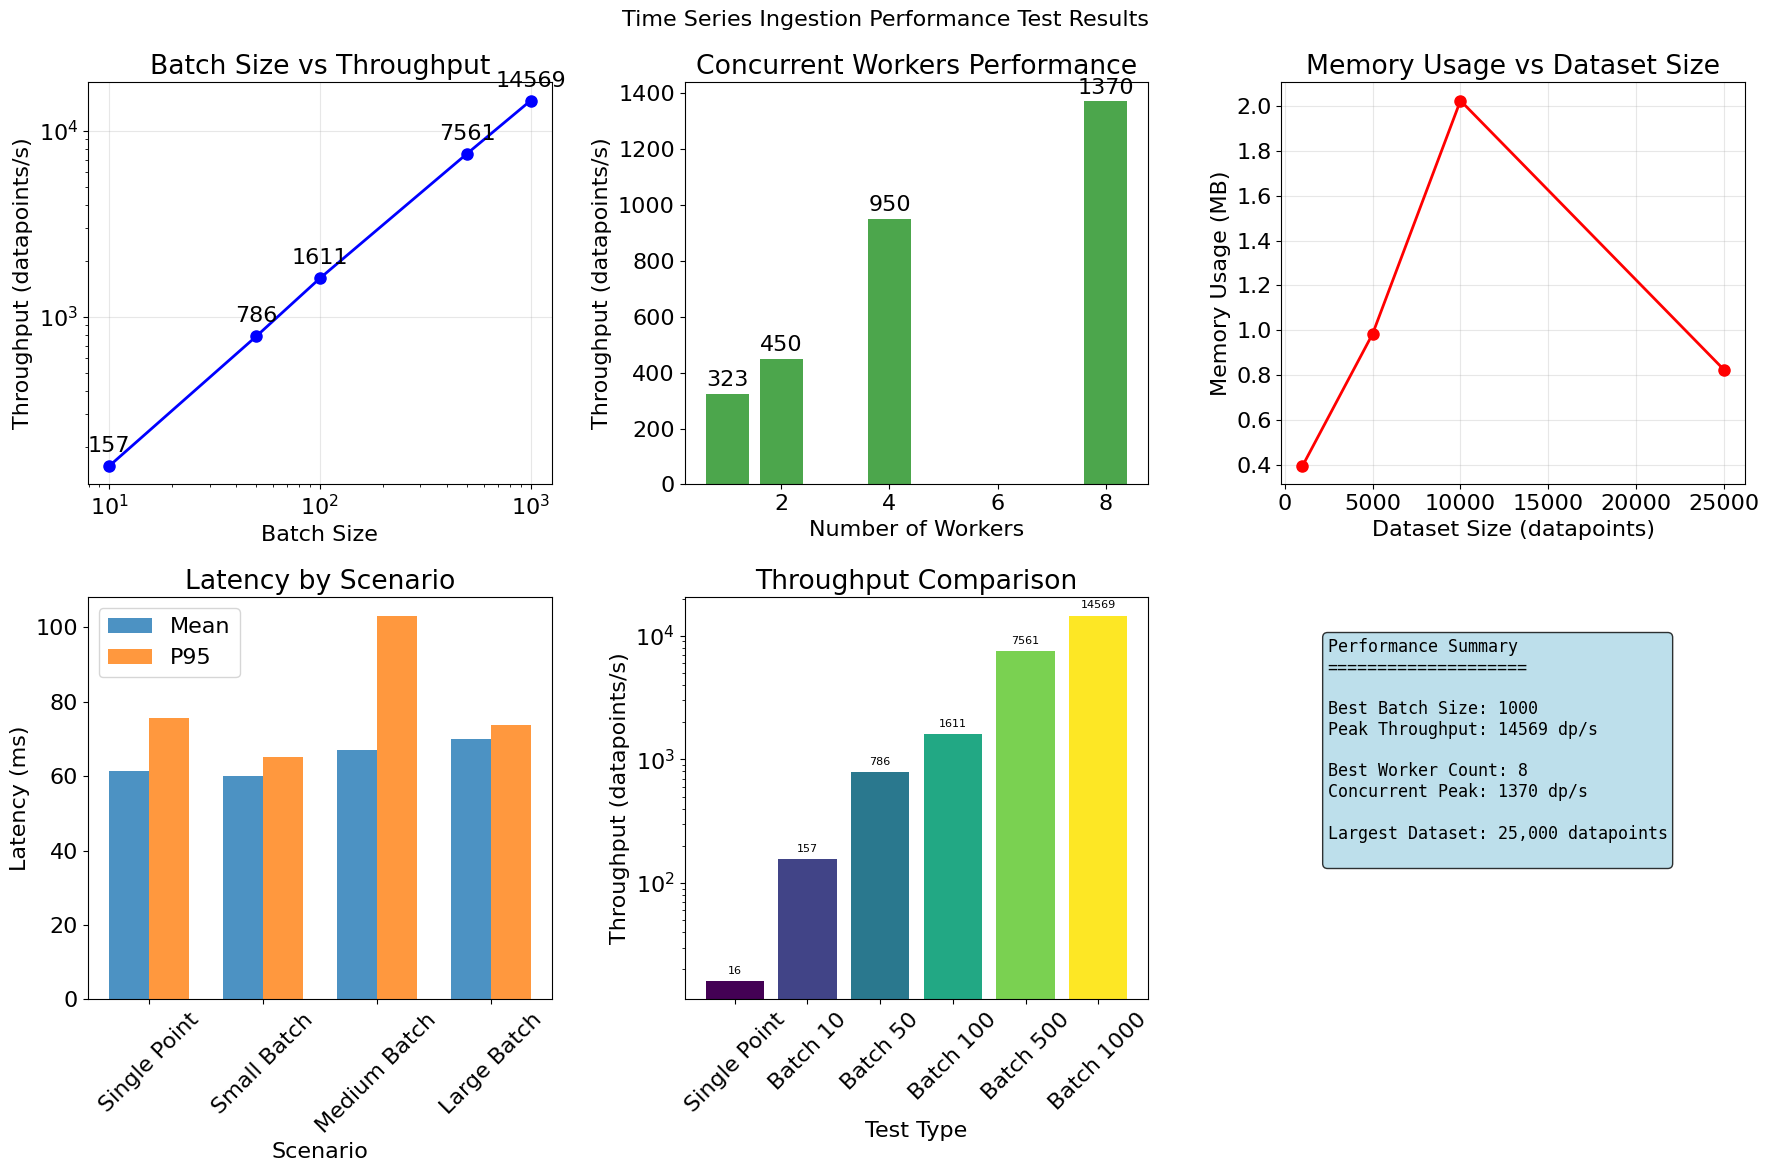

\n✅ Time series ingestion performance testing complete!
💾 Results can be saved using the PerformanceTracker.save_results() method


In [28]:
# Performance Results Summary and Visualization
def summarize_and_visualize_timeseries_results():
    """Summarize all time series ingestion performance test results and create visualizations."""
    
    print("📈 Time Series Ingestion Performance Test Results Summary")
    print("=" * 70)
    
    # Check if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        PLOTTING_AVAILABLE = True
    except ImportError:
        PLOTTING_AVAILABLE = False
        print("⚠️ Matplotlib not available. Install with: pip install matplotlib")
    
    # Summarize single datapoint test
    if 'single_stats' in globals() and single_stats:
        print("\n📍 Single Datapoint Insertion Performance:")
        print(f"  Average insertion time: {single_stats['mean']:.4f}s")
        print(f"  Throughput: {1/single_stats['mean']:.2f} datapoints/s")
        print(f"  Standard deviation: {single_stats['std_dev']:.4f}s")
    
    # Summarize batch insertion test
    if 'batch_results' in globals() and batch_results:
        print("\n📦 Batch Insertion Performance:")
        for batch_size, results in batch_results.items():
            if isinstance(results, dict) and 'mean_time' in results:
                throughput = batch_size / results['mean_time']
                print(f"  Batch size {batch_size:4d}: {results['mean_time']:.4f}s avg | {throughput:8.2f} datapoints/s")
    
    # Summarize concurrent test
    if 'concurrent_results' in globals() and concurrent_results:
        print("\n🔄 Concurrent Insertion Performance:")
        for workers, results in concurrent_results.items():
            if isinstance(results, dict) and 'overall_throughput' in results:
                print(f"  {workers} workers: {results['overall_throughput']:8.2f} datapoints/s | {results['total_time']:.2f}s total")
    
    # Summarize memory test
    if 'memory_results' in globals() and memory_results:
        print("\n💾 Memory Usage Performance:")
        for size, results in memory_results.items():
            if isinstance(results, dict) and results.get('success'):
                print(f"  {size:5d} datapoints: {results['throughput']:8.2f} datapoints/s | {results['memory_total_mb']:.1f} MB | {results['memory_per_datapoint_kb']:.3f} KB/dp")
    
    # Summarize latency test
    if 'latency_results' in globals() and latency_results:
        print("\n⏱️ Latency Performance:")
        for scenario, results in latency_results.items():
            if isinstance(results, dict) and 'mean_latency_ms' in results:
                print(f"  {scenario:12s}: {results['mean_latency_ms']:6.2f}ms avg | P95: {results['p95_latency_ms']:6.2f}ms | P99: {results['p99_latency_ms']:6.2f}ms")
    
    # Create visualizations if matplotlib is available
    if PLOTTING_AVAILABLE:
        try:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('Time Series Ingestion Performance Test Results', fontsize=16)
            
            # Plot 1: Batch Size vs Throughput
            if 'batch_results' in globals() and batch_results:
                ax = axes[0, 0]
                batch_sizes = []
                throughputs = []
                
                for batch_size, results in batch_results.items():
                    if isinstance(results, dict) and 'mean_time' in results:
                        batch_sizes.append(batch_size)
                        throughputs.append(batch_size / results['mean_time'])
                
                if batch_sizes:
                    ax.loglog(batch_sizes, throughputs, 'bo-', linewidth=2, markersize=8)
                    ax.set_xlabel('Batch Size')
                    ax.set_ylabel('Throughput (datapoints/s)')
                    ax.set_title('Batch Size vs Throughput')
                    ax.grid(True, alpha=0.3)
                    
                    # Add value labels
                    for x, y in zip(batch_sizes, throughputs):
                        ax.annotate(f'{y:.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
            
            # Plot 2: Concurrent Workers Performance
            if 'concurrent_results' in globals() and concurrent_results:
                ax = axes[0, 1]
                workers = []
                throughputs = []
                
                for num_workers, results in concurrent_results.items():
                    if isinstance(results, dict) and 'overall_throughput' in results:
                        workers.append(num_workers)
                        throughputs.append(results['overall_throughput'])
                
                if workers:
                    ax.bar(workers, throughputs, color='green', alpha=0.7)
                    ax.set_xlabel('Number of Workers')
                    ax.set_ylabel('Throughput (datapoints/s)')
                    ax.set_title('Concurrent Workers Performance')
                    
                    # Add value labels on bars
                    for x, y in zip(workers, throughputs):
                        ax.text(x, y + max(throughputs) * 0.01, f'{y:.0f}', ha='center', va='bottom')
            
            # Plot 3: Memory Usage
            if 'memory_results' in globals() and memory_results:
                ax = axes[0, 2]
                sizes = []
                memory_usage = []
                
                for size, results in memory_results.items():
                    if isinstance(results, dict) and results.get('success'):
                        sizes.append(size)
                        memory_usage.append(results['memory_total_mb'])
                
                if sizes:
                    ax.plot(sizes, memory_usage, 'ro-', linewidth=2, markersize=8)
                    ax.set_xlabel('Dataset Size (datapoints)')
                    ax.set_ylabel('Memory Usage (MB)')
                    ax.set_title('Memory Usage vs Dataset Size')
                    ax.grid(True, alpha=0.3)
            
            # Plot 4: Latency Distribution
            if 'latency_results' in globals() and latency_results:
                ax = axes[1, 0]
                scenarios = []
                mean_latencies = []
                p95_latencies = []
                
                for scenario, results in latency_results.items():
                    if isinstance(results, dict) and 'mean_latency_ms' in results:
                        scenarios.append(scenario.replace('_', ' ').title())
                        mean_latencies.append(results['mean_latency_ms'])
                        p95_latencies.append(results['p95_latency_ms'])
                
                if scenarios:
                    x = np.arange(len(scenarios))
                    width = 0.35
                    
                    ax.bar(x - width/2, mean_latencies, width, label='Mean', alpha=0.8)
                    ax.bar(x + width/2, p95_latencies, width, label='P95', alpha=0.8)
                    
                    ax.set_xlabel('Scenario')
                    ax.set_ylabel('Latency (ms)')
                    ax.set_title('Latency by Scenario')
                    ax.set_xticks(x)
                    ax.set_xticklabels(scenarios, rotation=45)
                    ax.legend()
            
            # Plot 5: Throughput Comparison
            ax = axes[1, 1]
            test_names = []
            throughputs = []
            
            # Collect throughput data from all tests
            if 'single_stats' in globals() and single_stats:
                test_names.append('Single Point')
                throughputs.append(1/single_stats['mean'])
            
            if 'batch_results' in globals() and batch_results:
                for batch_size, results in batch_results.items():
                    if isinstance(results, dict) and 'mean_time' in results:
                        test_names.append(f'Batch {batch_size}')
                        throughputs.append(batch_size / results['mean_time'])
            
            if test_names:
                colors = plt.cm.viridis(np.linspace(0, 1, len(test_names)))
                bars = ax.bar(range(len(test_names)), throughputs, color=colors)
                ax.set_xlabel('Test Type')
                ax.set_ylabel('Throughput (datapoints/s)')
                ax.set_title('Throughput Comparison')
                ax.set_xticks(range(len(test_names)))
                ax.set_xticklabels(test_names, rotation=45)
                ax.set_yscale('log')
                
                # Add value labels
                for i, (bar, throughput) in enumerate(zip(bars, throughputs)):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1,
                           f'{throughput:.0f}', ha='center', va='bottom', fontsize=8)
            
            # Plot 6: Performance Summary
            ax = axes[1, 2]
            ax.axis('off')
            
            # Create summary text
            summary_text = "Performance Summary\n" + "="*20 + "\n\n"
            
            if 'batch_results' in globals() and batch_results:
                best_batch = max(batch_results.items(), 
                               key=lambda x: x[0]/x[1]['mean_time'] if isinstance(x[1], dict) and 'mean_time' in x[1] else 0)
                if isinstance(best_batch[1], dict):
                    best_throughput = best_batch[0] / best_batch[1]['mean_time']
                    summary_text += f"Best Batch Size: {best_batch[0]}\n"
                    summary_text += f"Peak Throughput: {best_throughput:.0f} dp/s\n\n"
            
            if 'concurrent_results' in globals() and concurrent_results:
                best_concurrent = max(concurrent_results.items(),
                                    key=lambda x: x[1].get('overall_throughput', 0) if isinstance(x[1], dict) else 0)
                if isinstance(best_concurrent[1], dict):
                    summary_text += f"Best Worker Count: {best_concurrent[0]}\n"
                    summary_text += f"Concurrent Peak: {best_concurrent[1]['overall_throughput']:.0f} dp/s\n\n"
            
            if 'memory_results' in globals() and memory_results:
                largest_successful = max([size for size, results in memory_results.items() 
                                        if isinstance(results, dict) and results.get('success')], default=0)
                if largest_successful:
                    summary_text += f"Largest Dataset: {largest_successful:,} datapoints\n"
            
            ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"\\n📊 Visualization error: {e}")
    else:
        print("\\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\\n✅ Time series ingestion performance testing complete!")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_timeseries_results()


In [29]:
# Comprehensive Cleanup Section

def cleanup_all_timeseries_test_resources():
    """Clean up ALL time series test resources with enhanced fault tolerance."""
    
    if client is None:
        print("❌ Cannot cleanup: Client not available.")
        return
    
    print("🧹 Starting cleanup of all time series test resources...")
    print("⚠️ This will remove all performance test time series!")
    print("=" * 60)
    
    total_stats = {
        "timeseries_deleted": 0,
        "timeseries_skipped": 0,
        "datapoints_deleted": 0,
        "errors": 0,
        "retries": 0
    }
    
    def safe_delete_with_retry(operation_name, delete_func, max_retries=3):
        """Safely execute a delete operation with retries."""
        for attempt in range(max_retries):
            try:
                delete_func()
                return True
            except Exception as e:
                total_stats["retries"] += 1
                if attempt == max_retries - 1:
                    print(f"      ❌ Failed {operation_name} after {max_retries} attempts: {e}")
                    total_stats["errors"] += 1
                    return False
                else:
                    print(f"      ⚠️ Retry {attempt + 1} for {operation_name}: {e}")
                    time.sleep(1)  # Brief pause before retry
        return False
    
    try:
        # STEP 1: Collect all test time series from test results
        print("🔹 STEP 1: Collecting test time series from results...")
        
        all_test_timeseries = set()
        
        # Collect from test result metadata
        for test_results in [
            globals().get('concurrent_results', {}),
            globals().get('memory_results', {}),
            globals().get('latency_results', {})
        ]:
            if test_results and isinstance(test_results, dict):
                cleanup_list = test_results.get('_cleanup_timeseries', [])
                all_test_timeseries.update(cleanup_list)
        
        print(f"    Found {len(all_test_timeseries)} test time series from metadata")
        
        # STEP 2: Find all time series with performance test patterns
        print("🔹 STEP 2: Scanning for performance test time series...")
        
        try:
            all_timeseries = client.time_series.list()
            
            test_patterns = [
                'performance_test_',
                'perf_concurrent_',
                'perf_memory_',
                'perf_latency_'
            ]
            
            pattern_matches = []
            for ts in all_timeseries:
                if ts.external_id:
                    for pattern in test_patterns:
                        if ts.external_id.startswith(pattern):
                            pattern_matches.append(ts.external_id)
                            break
            
            print(f"    Found {len(pattern_matches)} time series matching test patterns")
            all_test_timeseries.update(pattern_matches)
            
        except Exception as e:
            print(f"    ⚠️ Warning: Could not list time series: {e}")
            total_stats["errors"] += 1
        
        # STEP 3: Delete all identified test time series
        print(f"🔹 STEP 3: Deleting {len(all_test_timeseries)} test time series...")
        
        for ts_external_id in all_test_timeseries:
            try:
                print(f"    Processing: {ts_external_id}")
                
                # Try to delete time series data first (optional, but good practice)
                try:
                    # Get time series info to check if it exists
                    ts_info = client.time_series.retrieve(external_id=ts_external_id)
                    if ts_info:
                        # Try to delete datapoints (optional step)
                        try:
                            # Delete all datapoints for this time series
                            client.time_series.data.delete_ranges(
                                external_id=ts_external_id,
                                ranges=[(0, int(time.time() * 1000) + 86400000)]  # From epoch to tomorrow
                            )
                            total_stats["datapoints_deleted"] += 1
                        except Exception:
                            pass  # Datapoint deletion is optional
                except Exception:
                    pass  # Time series might not exist
                
                # Delete the time series itself
                def delete_timeseries():
                    client.time_series.delete(external_id=ts_external_id)
                
                if safe_delete_with_retry(f"time series {ts_external_id}", delete_timeseries):
                    total_stats["timeseries_deleted"] += 1
                    print(f"      ✅ Deleted: {ts_external_id}")
                else:
                    total_stats["timeseries_skipped"] += 1
                    
            except Exception as e:
                print(f"    ⚠️ Error processing {ts_external_id}: {e}")
                total_stats["timeseries_skipped"] += 1
        
        # STEP 4: Final verification
        print("🔹 STEP 4: Final verification...")
        
        try:
            remaining_timeseries = client.time_series.list()
            remaining_test_timeseries = []
            
            for ts in remaining_timeseries:
                if ts.external_id:
                    for pattern in test_patterns:
                        if ts.external_id.startswith(pattern):
                            remaining_test_timeseries.append(ts.external_id)
                            break
            
            if remaining_test_timeseries:
                print(f"    ⚠️ Found {len(remaining_test_timeseries)} remaining test time series:")
                for ts_id in remaining_test_timeseries[:5]:  # Show first 5
                    print(f"      - {ts_id}")
                if len(remaining_test_timeseries) > 5:
                    print(f"      ... and {len(remaining_test_timeseries) - 5} more")
            else:
                print("    ✅ No remaining test time series found")
                
        except Exception as e:
            print(f"    Warning in verification: {e}")
    
    except Exception as e:
        print(f"❌ Critical error during cleanup: {e}")
        total_stats["errors"] += 1
    
    # Enhanced summary
    print("\\n" + "=" * 60)
    print("✅ TIME SERIES CLEANUP FINISHED!")
    print("📊 Summary:")
    print(f"  📈 Time series deleted: {total_stats['timeseries_deleted']}")
    print(f"  ❌ Time series skipped: {total_stats['timeseries_skipped']}")
    print(f"  📊 Datapoint ranges deleted: {total_stats['datapoints_deleted']}")
    print(f"  🔄 Retries performed: {total_stats['retries']}")
    print(f"  ⚠️ Errors encountered: {total_stats['errors']}")
    print("=" * 60)
    
    if total_stats['errors'] > 0:
        print("⚠️ Some cleanup operations failed. You may need to manually delete remaining resources.")
    elif total_stats['timeseries_skipped'] > 0:
        print("ℹ️ Some time series were skipped due to access issues or conflicts.")
    else:
        print("🎉 Cleanup completed successfully!")

def quick_timeseries_cleanup():
    """Quick cleanup function for immediate use."""
    print("🚀 Running quick time series cleanup...")
    
    if client is None:
        print("❌ Client not available")
        return
    
    stats = {"deleted": 0, "errors": 0}
    
    # Quick cleanup patterns
    test_patterns = ['performance_test_', 'perf_concurrent_', 'perf_memory_', 'perf_latency_']
    
    try:
        timeseries = client.time_series.list()
        for ts in timeseries:
            if ts.external_id:
                for pattern in test_patterns:
                    if ts.external_id.startswith(pattern):
                        try:
                            client.time_series.delete(external_id=ts.external_id)
                            stats["deleted"] += 1
                            print(f"  ✅ Deleted: {ts.external_id}")
                        except Exception as e:
                            stats["errors"] += 1
                            print(f"  ❌ Failed: {ts.external_id} - {e}")
                        break
    except Exception as e:
        print(f"Error in quick cleanup: {e}")
    
    print(f"Quick cleanup: {stats['deleted']} deleted, {stats['errors']} errors")

# Usage Instructions  
print("🧹 TIME SERIES CLEANUP FUNCTIONS READY")
print("=" * 50)
print("")
print("💡 To run complete cleanup:")
print("   cleanup_all_timeseries_test_resources()")
print("")
print("🚀 To run quick cleanup:")
print("   quick_timeseries_cleanup()")
print("")
print("⚠️ WARNING: These operations will permanently delete test time series!")
print("   - All performance test time series will be removed")
print("   - Associated datapoints will be deleted")
print("   - Cannot be undone")
print("")
print("🚀 Uncomment to run:")
print("# cleanup_all_timeseries_test_resources()")

# Uncomment the line below to run complete cleanup:
cleanup_all_timeseries_test_resources()


🧹 TIME SERIES CLEANUP FUNCTIONS READY

💡 To run complete cleanup:
   cleanup_all_timeseries_test_resources()

🚀 To run quick cleanup:
   quick_timeseries_cleanup()

⚠️ WARNING: These operations will permanently delete test time series!
   - All performance test time series will be removed
   - Associated datapoints will be deleted
   - Cannot be undone

🚀 Uncomment to run:
# cleanup_all_timeseries_test_resources()
🧹 Starting cleanup of all time series test resources...
⚠️ This will remove all performance test time series!
🔹 STEP 1: Collecting test time series from results...
    Found 23 test time series from metadata
🔹 STEP 2: Scanning for performance test time series...
    Found 7 time series matching test patterns
🔹 STEP 3: Deleting 28 test time series...
    Processing: perf_concurrent_4_3_1753452235
      ✅ Deleted: perf_concurrent_4_3_1753452235
    Processing: perf_concurrent_8_6_1753452236
      ✅ Deleted: perf_concurrent_8_6_1753452236
    Processing: perf_concurrent_4_0_1753